In [1]:
# First implementation of multi-objective optimization of infill patterns
# using pymoo optimization library with structural objectives based on
# FEA evaluation in FEniCS framework with Gmsh meshing

import numpy as np
import matplotlib.pyplot as plt
import pathlib
from pathlib import Path

from pymoo.core.problem import ElementwiseProblem
from pymoo.algorithms.moo.nsga2 import NSGA2

from pymoo.operators.sampling.rnd import BinaryRandomSampling
from pymoo.operators.crossover.hux import HalfUniformCrossover
from pymoo.operators.crossover.ux import UniformCrossover
from pymoo.operators.mutation.bitflip import BitflipMutation

from pymoo.termination import get_termination
from pymoo.optimize import minimize

import meshio
import gmsh
from dolfin import *

def create_mesh(mesh, cell_type):
    cells = mesh.get_cells_type(cell_type)
    cell_data = mesh.get_cell_data("gmsh:geometrical", cell_type)
    out_mesh = meshio.Mesh(points=mesh.points[:,:2], cells={cell_type: cells}, cell_data={"name_to_read": [cell_data]})
    return out_mesh


def extract_mesh_data(mesh_to_load):
    msh = meshio.read(mesh_to_load)

    # filepath management
    cwd = Path.cwd()
    temp_dir = cwd.joinpath("temp_mesh")   # temp dir for loading meshes
    temp_dir.mkdir(exist_ok=True)          # create parent dir if it does not exist


    infill_triangles = create_mesh(msh, "triangle")
    infill_lines = create_mesh(msh, "line")
    meshio.write(temp_dir / "mesh.xdmf", infill_triangles)
    meshio.write(temp_dir / "mf.xdmf", infill_lines)

    infill_mesh = Mesh()
    mvc = MeshValueCollection("size_t", infill_mesh, infill_mesh.topology().dim())
    with XDMFFile(str(temp_dir / "mesh.xdmf")) as infile:
        infile.read(infill_mesh)
        infile.read(mvc, "name_to_read")
    cf = cpp.mesh.MeshFunctionSizet(infill_mesh, mvc)

    mvc = MeshValueCollection("size_t", infill_mesh, infill_mesh.topology().dim() - 1)
    with XDMFFile(str(temp_dir / "mf.xdmf")) as infile:
        infile.read(mvc, "name_to_read")
    mf = cpp.mesh.MeshFunctionSizet(infill_mesh, mvc)

    infill_connect = infill_mesh.cells()       # triangle connectivity of the infill mesh
    infill_coords = infill_mesh.coordinates()  # coordinates within the infill mesh
    infill_coords = np.round(infill_coords, 4) # rounding the coordinates
    num_el = len(infill_connect)               # number of infill elements

    return infill_connect, infill_coords, num_el

def extract_mesh_data_fenics(mesh_to_load):
    msh = meshio.read(mesh_to_load)

    # filepath management
    cwd = Path.cwd()
    temp_dir = cwd.joinpath("temp_mesh")   # temp dir for loading meshes
    temp_dir.mkdir(exist_ok=True)          # create parent dir if it does not exist

    triangle_mesh = create_mesh(msh, "triangle")
    line_mesh = create_mesh(msh, "line")
    meshio.write(temp_dir / "mesh.xdmf", triangle_mesh)
    meshio.write(temp_dir / "mf.xdmf", line_mesh)

    mesh = Mesh()
    mvc = MeshValueCollection("size_t", mesh, mesh.topology().dim())
    with XDMFFile(str(temp_dir / "mesh.xdmf")) as infile:
        infile.read(mesh)
        infile.read(mvc, "name_to_read")
    cf = cpp.mesh.MeshFunctionSizet(mesh, mvc)

    mvc = MeshValueCollection("size_t", mesh, mesh.topology().dim() - 1)
    with XDMFFile(str(temp_dir / "mf.xdmf")) as infile:
        infile.read(mvc, "name_to_read")
    mf = cpp.mesh.MeshFunctionSizet(mesh, mvc)

    return mesh, mvc, cf, mf

def generate_infill_file(meshpath, infill_vec, infill_connect, infill_coords, verbosity=1, run_GUI=False):
    size = 10  # physical dimension of the side
    P = 1      # number of perimeters
    ex = 0.5   # extrusion width (one perimeter width)
    width, height = size, size       # setting up the square
    num_el_x, num_el_y = 2 * size, 2 * size  # adjust the num of elements
    num_el_x_inf, num_el_y_inf = 7, 7  # adjust num of elems for infill
    dx, dy = width / num_el_x, height / num_el_y

    # initialize Gmsh
    if not gmsh.is_initialized():
        gmsh.initialize()
        gmsh.option.setNumber('General.Verbosity', verbosity)

    gmsh.model.add(meshpath.stem)  # "smallSquare8-vecEl-substractive"

    # preparing parameters
    lc = 3 * ex     # mesh size

    # defining a namespace
    gmo = gmsh.model.occ  # gmo ~ gmsh.model.opencascade
    gmg = gmsh.model.geo  # gmg ~ gmsh.model.geo

    # defining the points
    gmo.addPoint(0, 0, 0, lc, 1)
    gmo.addPoint(0, size, 0, lc, 2)
    gmo.addPoint(size, size, 0, lc, 3)
    gmo.addPoint(size, 0, 0, lc, 4)

    # adding lines
    gmo.addLine(1, 2, 1)
    gmo.addLine(2, 3, 2)
    gmo.addLine(3, 4, 3)
    gmo.addLine(4, 1, 4)

    # defining a new surface:
    gmo.addCurveLoop([1, 2, 3, 4], 20)
    surf = gmo.addPlaneSurface([20])  # full surface
    gmo.synchronize()

    # meshing the transfinite surface
    gmsh.model.mesh.setTransfiniteCurve(1, num_el_x + 1)
    gmsh.model.mesh.setTransfiniteCurve(2, num_el_x + 1)
    gmsh.model.mesh.setTransfiniteCurve(3, num_el_x + 1)
    gmsh.model.mesh.setTransfiniteCurve(4, num_el_x + 1)
    gmo.synchronize()
    gmsh.model.mesh.setTransfiniteSurface(surf, arrangement="Alternate", cornerTags=[1,2,3,4])


    # subtracting individual infill elements
    infill_points = []   # list of point tags inside the infill
    for x, y in infill_coords:
        infill_points.append(gmo.addPoint(x, y, 0, lc))  # add each point

    infill_lines = []   # list of line tags inside the infill
    infill_curves = []  # list of curve tags inside the infill
    infill_surfs = []   # list of surface tags
    for i, tri in enumerate(infill_connect):   # get each point in each triangle
        if infill_vec[i] == 0:                 # only if is to be deleted (0: not included)
            p1, p2, p3 = tri[0], tri[1], tri[2]
            tp1 = infill_points[p1]  # tag of p1
            tp2 = infill_points[p2]  # tag of p2
            tp3 = infill_points[p3]  # tag of p3
            l1 = gmo.addLine(tp1, tp2)  # tag of line 1
            l2 = gmo.addLine(tp2, tp3)  # tag of line 2
            l3 = gmo.addLine(tp3, tp1)  # tag of line 3
            xp1, yp1 = infill_coords[p1, 0], infill_coords[p1, 1]  # getting coords of p1
            xp2, yp2 = infill_coords[p2, 0], infill_coords[p2, 1]  # getting coords of p2
            xp3, yp3 = infill_coords[p3, 0], infill_coords[p3, 1]  # getting coords of p3
            infill_lines.append(l1)
            infill_lines.append(l2)
            infill_lines.append(l3)
            c1 = gmo.addCurveLoop([l1, l2, l3])
            s1 = gmo.addPlaneSurface([c1])  # create the surface
            infill_curves.append(c1)
            infill_surfs.append(s1)
    gmo.synchronize()

    surfs_to_cut = [(2, tag) for tag in infill_surfs]  # list of all surfs
    if len(surfs_to_cut) > 0:
        # substract all in one
        outlab = gmo.cut([(2, surf)], surfs_to_cut, removeObject=True, removeTool=True)
        surf = outlab[0][0][1]
        gmo.synchronize()

    # extract the curve boundary
    Boundary = [tg for tp, tg in gmsh.model.getBoundary([(2, surf)])]

    # adding physical groups
    gmsh.model.addPhysicalGroup(1, Boundary, name="SurfaceLoop") # curves physical group
    gmsh.model.addPhysicalGroup(2, [surf], name="PerimeterSurface")   # surfaces physical group
    gmo.synchronize()

    # global meshing options
    gmsh.option.setNumber("Mesh.Algorithm", 6)  # Frontal-Delaunay for 2D meshes


    # generate the mesh
    gmo.synchronize()
    gmsh.model.mesh.generate(2)

    # saving the mesh
    gmsh.write(str(meshpath))

    # Launch the GUI
    if run_GUI:
        gmo.synchronize()
        gmsh.fltk.run()

    # finish the GMSH session
    gmsh.finalize()


def generate_img_file(meshpath, infill_vec, infill_connect, infill_coords, verbosity=1):
    size = 10  # physical dimension of the side
    P = 1      # number of perimeters
    ex = 0.5   # extrusion width (one perimeter width)
    width, height = size, size       # setting up the square
    num_el_x, num_el_y = 2 * size, 2 * size  # adjust the num of elements
    num_el_x_inf, num_el_y_inf = 7, 7  # adjust num of elems for infill
    dx, dy = width / num_el_x, height / num_el_y

    # initialize Gmsh
    if not gmsh.is_initialized():
        gmsh.initialize()
        gmsh.option.setNumber('General.Verbosity', verbosity)

    gmsh.model.add(meshpath.stem)  # "smallSquare8-vecEl-substractive"

    # preparing parameters
    lc = 3 * ex     # mesh size

    # defining a namespace
    gmo = gmsh.model.occ  # gmo ~ gmsh.model.opencascade
    gmg = gmsh.model.geo  # gmg ~ gmsh.model.geo

    # defining the points
    gmo.addPoint(0, 0, 0, lc, 1)
    gmo.addPoint(0, size, 0, lc, 2)
    gmo.addPoint(size, size, 0, lc, 3)
    gmo.addPoint(size, 0, 0, lc, 4)

    # adding lines
    gmo.addLine(1, 2, 1)
    gmo.addLine(2, 3, 2)
    gmo.addLine(3, 4, 3)
    gmo.addLine(4, 1, 4)

    # defining a new surface:
    gmo.addCurveLoop([1, 2, 3, 4], 20)
    surf = gmo.addPlaneSurface([20])  # full surface
    gmo.synchronize()

    # meshing the transfinite surface
    gmsh.model.mesh.setTransfiniteCurve(1, num_el_x + 1)
    gmsh.model.mesh.setTransfiniteCurve(2, num_el_x + 1)
    gmsh.model.mesh.setTransfiniteCurve(3, num_el_x + 1)
    gmsh.model.mesh.setTransfiniteCurve(4, num_el_x + 1)
    gmo.synchronize()
    gmsh.model.mesh.setTransfiniteSurface(surf, arrangement="Alternate", cornerTags=[1,2,3,4])


    # subtracting individual infill elements
    infill_points = []   # list of point tags inside the infill
    for x, y in infill_coords:
        infill_points.append(gmo.addPoint(x, y, 0, lc))  # add each point

    infill_lines = []   # list of line tags inside the infill
    infill_curves = []  # list of curve tags inside the infill
    infill_surfs = []   # list of surface tags
    for i, tri in enumerate(infill_connect):   # get each point in each triangle
        if infill_vec[i] == 0:                 # only if is to be deleted (0: not included)
            p1, p2, p3 = tri[0], tri[1], tri[2]
            tp1 = infill_points[p1]  # tag of p1
            tp2 = infill_points[p2]  # tag of p2
            tp3 = infill_points[p3]  # tag of p3
            l1 = gmo.addLine(tp1, tp2)  # tag of line 1
            l2 = gmo.addLine(tp2, tp3)  # tag of line 2
            l3 = gmo.addLine(tp3, tp1)  # tag of line 3
            xp1, yp1 = infill_coords[p1, 0], infill_coords[p1, 1]  # getting coords of p1
            xp2, yp2 = infill_coords[p2, 0], infill_coords[p2, 1]  # getting coords of p2
            xp3, yp3 = infill_coords[p3, 0], infill_coords[p3, 1]  # getting coords of p3
            infill_lines.append(l1)
            infill_lines.append(l2)
            infill_lines.append(l3)
            c1 = gmo.addCurveLoop([l1, l2, l3])
            s1 = gmo.addPlaneSurface([c1])  # create the surface
            infill_curves.append(c1)
            infill_surfs.append(s1)
    gmo.synchronize()

    surfs_to_cut = [(2, tag) for tag in infill_surfs]  # list of all surfs
    if len(surfs_to_cut) > 0:
        # substract all in one
        outlab = gmo.cut([(2, surf)], surfs_to_cut, removeObject=True, removeTool=True)
        surf = outlab[0][0][1]
        gmo.synchronize()

    # extract the curve boundary
    Boundary = [tg for tp, tg in gmsh.model.getBoundary([(2, surf)])]

    # adding physical groups
    gmsh.model.addPhysicalGroup(1, Boundary, name="SurfaceLoop") # curves physical group
    gmsh.model.addPhysicalGroup(2, [surf], name="PerimeterSurface")   # surfaces physical group
    gmo.synchronize()

    # global meshing options
    gmsh.option.setNumber("Mesh.Algorithm", 6)  # Frontal-Delaunay for 2D meshes

    # setting up the appearence
    gmsh.option.setNumber("Mesh.ColorCarousel", 0)  # visibility setup
    gmsh.option.setNumber("Mesh.Triangles", 1)      # visibility setup
    gmsh.option.setNumber("Geometry.Points", 0)     # visibility setup
    gmsh.option.setNumber("Mesh.SurfaceFaces", 1)   # visibility setup
    gmsh.option.setNumber("Mesh.Lines", 0)          # visibility setup
    gmsh.option.setNumber("General.SmallAxes", 0)   # visibility setup
    gmsh.option.setNumber("Mesh.LineWidth", 2)      # width setup
    gmsh.option.setNumber("Mesh.Light", 0)          # light setup

    #gmsh.option.setColor("Geometry.Color.Points", 255, 165, 0)  # setting the color
    #gmsh.option.setColor("General.Color.Text", 255, 255, 255)   # setting the color

    gmsh.option.setColor("Mesh.Color.Lines", 210, 200, 185)       # setting the color
    gmsh.option.setColor("Mesh.Color.Triangles", 30, 30, 190)     # setting the color
    #gmsh.option.setColor("Mesh.SurfaceFaces", 0, 255, 0, 1)
    # gmsh.option.setColor("Mesh.SurfaceFaces", 0, 200, 0, 10)

    # generate the mesh
    gmo.synchronize()
    gmsh.model.mesh.generate(2)

    # Launch the GUI and saving the mesh
    gmo.synchronize()
    gmsh.fltk.initialize()
    gmsh.write(str(meshpath))

    # close the GUI
    gmsh.fltk.finalize()

    # finish the GMSH session
    gmsh.finalize()

# load solutions from the txt file
def load_txt_solutions(path_solutions):  # out_dir / "sq_solutions.txt"
    with open(path_solutions, "r") as f:
        lines = f.readlines()
        header = lines[0]
        text = lines[1:]

        X = []
        F1, F2 = [], []
        for line in text:
            sline = line.split('\t')
            vec = sline[0].replace('[','').replace(']','').replace(' ','')
            x = [int(el) for el in vec.split(',')]
            x = np.array(x)

            f1 = sline[1].replace(' ','').split(':')[1]
            f1 = float(f1)
            f2 = sline[2].replace(' ','').split(':')[1]
            f2 = float(f2)

            X.append(x)
            F1.append(f1)
            F2.append(f2)
    F1, F2 = np.array(F1), np.array(F2)
    F = np.vstack((F1, F2)).T
    X = np.vstack(X)
    return F, X


In [2]:
# FEniCS functions setup

# boundary connection setup
tol = 1
def clamped_middle(x, on_boundary): # beam is only fixed in the middle
    #return on_boundary and near(x[0], 0, tol) and near(x[1], 20, tol)#x[0] < tol
    return on_boundary and near(x[0], 0 + 0.25, tol) and near(x[1], 5, tol)#x[0] < tol

# Define strain
def epsilon(u):
    return 0.5*(nabla_grad(u) + nabla_grad(u).T)
    # return sym(nabla_grad(u))

# Define stress
def sigma(u, lambda_, d, mu):
    return lambda_*nabla_div(u)*Identity(d) + 2*mu*epsilon(u)

# Delta function for point load
class Delta(UserExpression):
    def __init__(self, eps, x0, **kwargs):
        self.eps = eps
        self.x0 = x0
        UserExpression.__init__(self, **kwargs)
    def eval(self, values, x):
        eps = self.eps
        values[0] = eps/pi/(np.linalg.norm(x-self.x0)**2 + eps**2)
        values[1] = 0
    def value_shape(self): return (2, )

# Obtain max, total and average displacements
def get_displacement_measures(u, V):
    u_magnitude = sqrt(dot(u, u))
    u_magnitude = project(u_magnitude, V)
    u_magnitude = u_magnitude.vector()
    disp_len = u_magnitude.size()
    disp_max = u_magnitude.max()   # maximal displacement
    disp_tot = u_magnitude.sum()   # total/sum displacement
    disp_avg = disp_tot / disp_len # average displacement
    return disp_max, disp_tot, disp_avg

# returns displacements and vm stress for side-compression of the square
def square_FEA(mesh, verbose=False, plotting=False):
    if not verbose:
        set_log_active(False)  # dolfin verbose to false
    else:
        set_log_active(True)   # dolfin verbose to true

    # Define function space for system of PDEs
    degree = 2
    lambda_ = 1
    mu = 1
    V = VectorFunctionSpace(mesh, 'P', degree)

    # Define boundary conditions
    bc1 = DirichletBC(V, Constant((0, 0)), clamped_middle)
    bcs = [bc1]  # combined boundary conditions
    delta = Delta(eps=1E-4, x0=np.array([9.75, 5]), degree=5)  # point load at x0

    # Define variational problem
    u = TrialFunction(V)
    d = u.geometric_dimension()   # space dimension
    v = TestFunction(V)
    f = Constant((0, 0))
    T = Constant((0, 0))
    a = inner(sigma(u, lambda_, d, mu), epsilon(v)) * dx
    L = inner(Constant(-10) * delta, v) * dx

    # Compute solution
    u = Function(V)
    solve(a == L, u, bcs)

    # Displacement measures
    V1 = FunctionSpace(mesh, 'P', 1)
    disp_max, disp_tot, disp_avg = get_displacement_measures(u, V1)
    if plotting:
        title_str = f"Displacement \n max:{round(disp_max,3)}  tot:{round(disp_tot,3)}  avg:{round(disp_avg,3)}"
        plot(u, title=title_str, mode='displacement')

    # max Von Mises Stress measure
    s = sigma(u, lambda_, d, mu) - (1./3) * tr(sigma(u, lambda_, d, mu)) * Identity(d)  # deviatoric stress
    von_mises = sqrt(3./2 * inner(s, s))
    von_mises = project(von_mises, V1)
    max_von_mises = von_mises.vector().max()  # getting maximal von Mises stress
    #plot(von_mises, title=f"Stress intensity, max vonMis:{max_von_mises}")###

    return disp_max, disp_tot, disp_avg, max_von_mises


Solving linear variational problem.
0.6035388457791071
0.044281909947494556


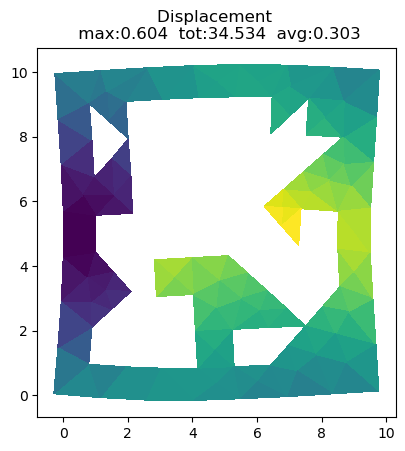

In [3]:
# Single iteration from Gmsh meshing to FEniCS in functions
import meshio
import gmsh
from ufl import nabla_div

cwd = Path.cwd()
mesh_dir = cwd.joinpath("MOEA_meshes", "smallSquare7x7")  # adjust the dir here
inf_file = str(mesh_dir.stem) + '-infill.msh'
mesh_inp = mesh_dir / inf_file

# Extracting geometry from the infill mesh
conn, coords, num_el = extract_mesh_data(mesh_inp)

# Create the mesh infill based on the infill vector
#vec = [0,0,1,1,0,0,0,0,1,1,0,0,0,0,1,1,0,0]
#vec = [0,0,0,0,0,1,1,1,0,0,0,0,0,0,1,1,1,1,1,0,1,1,1,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
vec = np.random.randint(2, size= 7 * 7 * 2)
meshfile = mesh_dir / 'infill_gen.msh'
generate_infill_file(meshfile, vec, conn, coords, run_GUI=False)

# Loading the created infill mesh to FEniCS
mesh, _, _, _ = extract_mesh_data_fenics(meshfile)

# perform FEA and obtain displacements and von mises stress
d_max, d_tot, d_avg, max_vm = square_FEA(mesh, verbose=True, plotting=True)

print(d_max)
print(max_vm)

In [4]:
# implementing pymoo multi-objective optimization with FEniCS FEA objectives

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.offsetbox import TextArea, DrawingArea, OffsetImage, AnnotationBbox
import pathlib
from pathlib import Path

from pymoo.core.problem import ElementwiseProblem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.termination import get_termination
from pymoo.optimize import minimize

from pymoo.operators.sampling.rnd import BinaryRandomSampling
from pymoo.operators.crossover.hux import HalfUniformCrossover
from pymoo.operators.crossover.ux import UniformCrossover
from pymoo.operators.crossover.pntx import TwoPointCrossover
from pymoo.operators.mutation.bitflip import BitflipMutation

from pymoo.decomposition.asf import ASF


# defining the multiobjective problem for square FEA problem: Weight/vm_stress obj
class MyProblem(ElementwiseProblem):

    def __init__(self, conn, coords, num_el, meshpath):
        super().__init__(n_var=num_el,
                         n_obj=2,
                         n_ieq_constr=0,
                         xl=np.zeros(num_el),
                         xu=np.ones(num_el)
                         )
        self.conn = conn
        self.coords = coords
        self.num_el = num_el
        self.meshpath = meshpath  # temp mesh for evaluation

    def _evaluate(self, x, out, *args, **kwargs):

        # generate the infill file
        generate_infill_file(self.meshpath, x, self.conn, self.coords)

        # Loading the created infill mesh to FEniCS
        mesh, _, _, _ = extract_mesh_data_fenics(meshfile)

        # perform FEA and obtain displacements and von mises stress
        d_max, d_tot, d_avg, max_vm = square_FEA(mesh)

        # objective values: we want to minimize *weight* and *maximal stress*
        f1 = np.sum(x)  # objective 1 - "weight"
        f2 = d_max     # objective 2 - "maxStress"

        # constraints
        #g1 = np.sum(x) - 200   # dummy constraint: can be adjusted to limit the infill rate

        out["F"] = [f1, f2]  # dictionary key for objectives
        #out["G"] = [g1]      # dictionary key for constraints


# Filepath management
cwd = Path.cwd()
mesh_dir = cwd.joinpath("MOEA_meshes", "smallSquare7x7")  # adjust the dir here
inf_file = str(mesh_dir.stem) + '-infill.msh'
mesh_inp = mesh_dir / inf_file  # mesh input file

# Extracting geometry from the infill mesh -> num_el is the design dimension
conn, coords, num_el = extract_mesh_data(mesh_inp)   # extracting the geometry

# init the MOP
meshfile = mesh_dir / 'infill_gen.msh'
problem = MyProblem(conn, coords, num_el, meshfile)


# initialize the algorithm object
algorithm = NSGA2(
    pop_size=100,
    n_offsprings=40,
    sampling=BinaryRandomSampling(),
    crossover=TwoPointCrossover(prob=1.0),
    #crossover=UniformCrossover(),
    mutation=BitflipMutation(prob=0.5, prob_var= 2 * 1/num_el),  # mutation scaled by the num of elements
    eliminate_duplicates=True
)


# define the termination criterion
termination = get_termination("n_gen", 1000)


# solve the MOP
res = minimize(problem,
               algorithm,
               termination,
               seed=1,
               save_history=True,
               verbose=True)

# n_gen  - generation counter,
# n_eval - number of evaluations
# cv_min - minimum constraint violation
# cv_avg - average constraint violation in the current population.
# n_nds  - number of non-dominated solutions
# eps/ind- running performance metrics

X = res.X  # solutions in the decision space
F = res.F  # solutions in the objective space
hist = res.history  # getting the info for each iteration

#print(X)
#print(F)

# save solutions
out_dir = mesh_dir / "infill_gen"
img_dir = out_dir / "png"
out_dir.mkdir(exist_ok=True)
img_dir.mkdir(exist_ok=True)
for i, x in enumerate(X):
    ifile = out_dir / f"sol{i:02d}.msh"  # generate mesh
    generate_infill_file(ifile, x, conn, coords)
    imfile = img_dir / f"sol_{i}.png"    # generate png
    generate_img_file(imfile, x, conn, coords)
    print(f"File {ifile.name} saved.")###

# writing to a file
with open(out_dir / "sq_solutions.txt", "w+") as file:
    alg = str(type(algorithm))[8:-2]
    header = f"Algorithm:{alg}, pop_size: {algorithm.pop_size},\
     n_offsp: {algorithm.n_offsprings}, n_gen: {termination.n_max_gen},\
     t_tot: {res.exec_time:10.1f}, t_gen: {res.exec_time/termination.n_max_gen:10.2f}\n"
    file.writelines(header)
    file.writelines(f"{str(list(sol))} \t w: {F[i][0]:10.1f} \t vm: {F[i][1]:10.06f} \n" for i, sol in enumerate(1*X))

# plotting the decision space
xl, xu = problem.bounds()
plt.figure(figsize=(7, 5))
plt.imshow(X)
plt.title("Design Space")
plt.show()


# plotting the objective space
plt.figure(figsize=(5, 3))
plt.scatter(F[:, 0], F[:, 1], s=20, facecolors='black', edgecolors='black')
plt.title("Objective Space")
plt.savefig(out_dir / 'ObjectiveSpace.png')
plt.show()


# Multi-Criteria Decision Making: subset selection
n_keep = 9  # how many solutions should we keep
if len(X) > n_keep:
    approx_ideal = F.min(axis=0)  # ideal point
    approx_nadir = F.max(axis=0)  # nadir point

    # normalizing with respect to both objectives
    nF = (F - approx_ideal) / (approx_nadir - approx_ideal)  # normalized objectives

    # Decision making: Using Augmented Scalarization Function (ASF)
    decomp = ASF()                  # init the ASF metric to be minimized
    weights = [np.array([(k + 1)/(n_keep+1), (n_keep - k)/(n_keep+1)]) for k in range(n_keep)]
    best_ASF = []  # indexes of chosen solutions
    for weight in weights:
        best_ASF.append(decomp.do(nF, 1/weight).argmin())  # index of the best solution regarding ASF
    best_ASF = list(set(best_ASF))  # remove duplicates
    F_ASF = F[best_ASF, :]          # objectives
    X_ASF = X[best_ASF, :]          # solutions
    n_kept = len(best_ASF)          # number of kept solutions


    # plotting the objective space with mesh png annotations
    fig, ax = plt.subplots(figsize=(13, 8))
    plt.scatter(F_ASF[:, 0], F_ASF[:, 1], s=20, facecolors='black', edgecolors='black')

    for i, (x, y) in enumerate(F_ASF):
        ind = best_ASF[i]
        img_lab = plt.imread(img_dir / f"sol_{ind}.png")
        imagebox = OffsetImage(img_lab, zoom=0.045)
        imagebox.image.axes = ax

        fl_offset = (-1)**i * 20  # spreading fluctuating offset
        ab = AnnotationBbox(imagebox, (x, y),
                            xybox=(32 - 0.6 * fl_offset, 38 + fl_offset),
                            xycoords='data',
                            boxcoords=("offset points", "offset points"),
                            pad=-1,
                            arrowprops=dict(
                                arrowstyle="->",
                                connectionstyle="angle,angleA=0,angleB=90,rad=3",
                                linewidth=0.5)
                            )
        ax.add_artist(ab)
        ax.text(x, y, f"  {str(ind)}", va='top', ha='left', zorder=4)

    xrang = np.abs(np.max(F_ASF[:,0]) - np.min(F_ASF[:,0]))
    yrang = np.abs(np.max(F_ASF[:,1]) - np.min(F_ASF[:,1]))
    ax.set_xlim((np.min(F_ASF[:,0]) - 0.05*xrang, np.max(F_ASF[:,0]) + 0.15*xrang ))
    ax.set_ylim((np.min(F_ASF[:,1]) - 0.1*yrang, np.max(F_ASF[:,1]) + 0.25*yrang ))
    plt.title(f"Objective Space of {n_kept} ASF-selected solutions")
    plt.savefig(out_dir / 'ObjectiveSpace-ASF.png')
    plt.show()




n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |      100 |      8 |             - |             -
     2 |      140 |      9 |  0.0055848231 |             f
     3 |      180 |     11 |  0.0079622850 |         ideal
     4 |      220 |     11 |  0.1052631579 |         ideal
     5 |      260 |     11 |  0.0272565097 |         nadir



KeyboardInterrupt



n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |      119 |     17 |             - |             -
     2 |      159 |     17 |  0.0036377542 |             f
     3 |      199 |     18 |  0.0019190389 |             f
     4 |      239 |     18 |  0.0024273893 |             f
     5 |      279 |     19 |  0.0294117647 |         ideal
     6 |      319 |     18 |  0.0016507815 |             f
     7 |      359 |     16 |  0.0967741935 |         nadir
     8 |      399 |     17 |  0.0312500000 |         ideal
     9 |      439 |     18 |  0.0155386209 |         nadir
    10 |      479 |     21 |  2.0409430491 |         nadir
    11 |      519 |     21 |  0.0303030303 |         ideal
    12 |      559 |     18 |  0.0073161419 |             f
    13 |      599 |     14 |  0.0132474574 |             f
    14 |      639 |     15 |  0.0294117647 |         ideal
    15 |      679 |     16 |  0.0065411654 |             f
    16 |      719 |     18 |  0.0555555556 |         ide

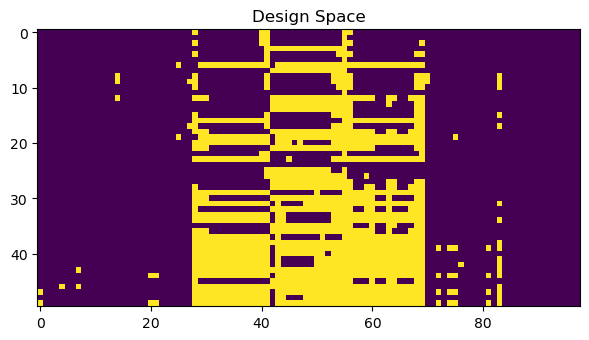

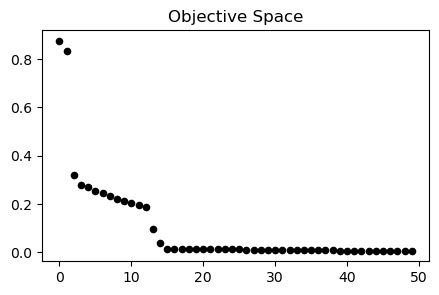

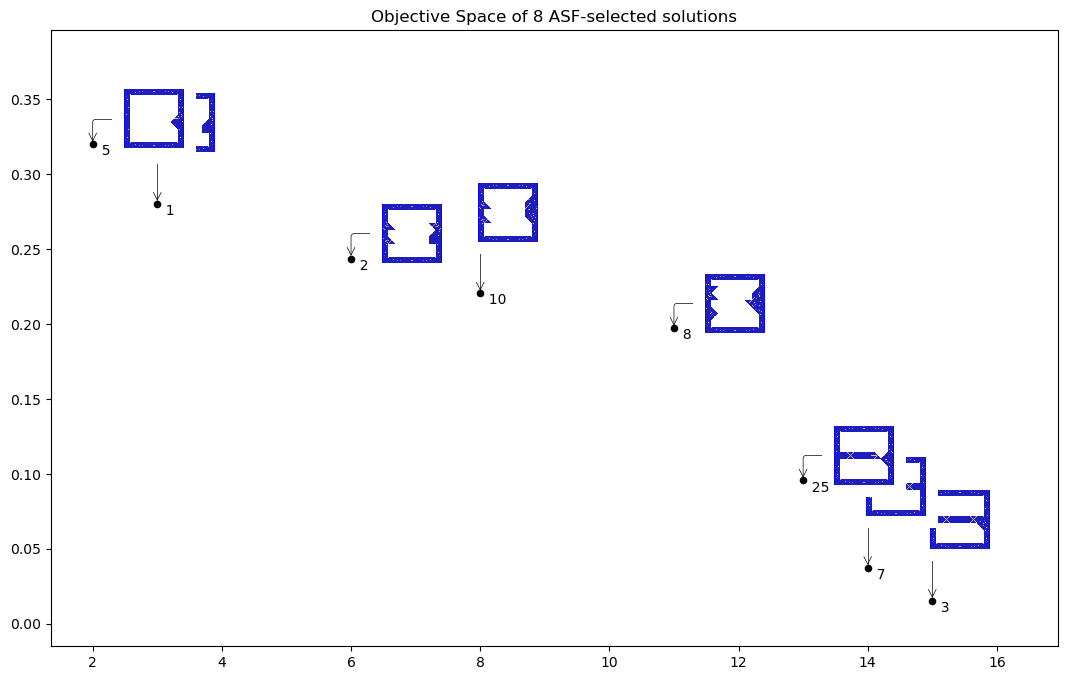

In [195]:
# with PRECOMPUTED sampling implementation (using older solutions)
# implementing pymoo multi-objective optimization with FEniCS FEA objectives

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.offsetbox import TextArea, DrawingArea, OffsetImage, AnnotationBbox
import pathlib
from pathlib import Path

from pymoo.core.problem import ElementwiseProblem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.termination import get_termination
from pymoo.optimize import minimize
from pymoo.core.sampling import Sampling

from pymoo.operators.sampling.rnd import BinaryRandomSampling
from pymoo.operators.crossover.hux import HalfUniformCrossover
from pymoo.operators.crossover.ux import UniformCrossover
from pymoo.operators.crossover.pntx import TwoPointCrossover
from pymoo.operators.mutation.bitflip import BitflipMutation

from pymoo.decomposition.asf import ASF


# use the solutions from
def PrecomputedSampling(n_samples):
    cwd = Path.cwd()
    mesh_dir = cwd.joinpath("MOEA_meshes", "smallSquare7x7")  # adjust the dir here
    out_dir = mesh_dir / "precomputed_solutions.txt"

    _, x = load_txt_solutions(txt_file)  # load precomputed solutions
    L = x.shape[0]

    X = np.random.randint(0, 2, size=(n_samples, 98), dtype=np.int32)

    for i in range(X.shape[1]):
        X[i,:] = x[i % L, :]

    X = X.astype(bool)
    return X

# defining the multiobjective problem for square FEA problem: Weight/max_disp obj
class MyProblem(ElementwiseProblem):

    def __init__(self, conn, coords, num_el, meshpath):
        super().__init__(n_var=num_el,
                         n_obj=2,
                         n_ieq_constr=0,
                         xl=np.zeros(num_el),
                         xu=np.ones(num_el)
                         )
        self.conn = conn
        self.coords = coords
        self.num_el = num_el
        self.meshpath = meshpath  # temp mesh for evaluation

    def _evaluate(self, x, out, *args, **kwargs):

        # generate the infill file
        generate_infill_file(self.meshpath, x, self.conn, self.coords)

        # Loading the created infill mesh to FEniCS
        mesh, _, _, _ = extract_mesh_data_fenics(meshfile)

        # perform FEA and obtain displacements and max displacement
        d_max, d_tot, d_avg, max_vm = square_FEA(mesh)

        # objective values: we want to minimize *weight* and *maximal stress*
        f1 = np.sum(x)  # objective 1 - "weight"
        f2 = d_max     # objective 2 - "maxDisplacement"

        # constraints
        #g1 = np.sum(x) - 200   # dummy constraint: can be adjusted to limit the infill rate

        out["F"] = [f1, f2]  # dictionary key for objectives
        #out["G"] = [g1]      # dictionary key for constraints


# Filepath management
cwd = Path.cwd()
mesh_dir = cwd.joinpath("MOEA_meshes", "smallSquare7x7")  # adjust the dir here
inf_file = str(mesh_dir.stem) + '-infill.msh'
mesh_inp = mesh_dir / inf_file  # mesh input file

# Extracting geometry from the infill mesh -> num_el is the design dimension
conn, coords, num_el = extract_mesh_data(mesh_inp)   # extracting the geometry

# init the MOP
meshfile = mesh_dir / 'infill_gen.msh'
problem = MyProblem(conn, coords, num_el, meshfile)


# initialize the algorithm object
algorithm = NSGA2(
    pop_size=100,
    n_offsprings=40,
    sampling=PrecomputedSampling(n_samples=200),
    crossover=TwoPointCrossover(prob=1.0),
    #crossover=UniformCrossover(),
    mutation=BitflipMutation(prob=0.5, prob_var= 2 * 1/num_el),  # mutation scaled by the num of elements
    eliminate_duplicates=True
)


# define the termination criterion
termination = get_termination("n_gen", 1000)


# solve the MOP
res = minimize(problem,
               algorithm,
               termination,
               seed=1,
               save_history=True,
               verbose=True)

# n_gen  - generation counter,
# n_eval - number of evaluations
# cv_min - minimum constraint violation
# cv_avg - average constraint violation in the current population.
# n_nds  - number of non-dominated solutions
# eps/ind- running performance metrics

X = res.X  # solutions in the decision space
F = res.F  # solutions in the objective space
hist = res.history  # getting the info for each iteration

#print(X)
#print(F)

# save solutions
out_dir = mesh_dir / "infill_gen"
img_dir = out_dir / "png"
out_dir.mkdir(exist_ok=True)
img_dir.mkdir(exist_ok=True)
for i, x in enumerate(X):
    ifile = out_dir / f"sol{i:02d}.msh"  # generate mesh
    generate_infill_file(ifile, x, conn, coords)
    imfile = img_dir / f"sol_{i}.png"    # generate png
    generate_img_file(imfile, x, conn, coords)
    print(f"File {ifile.name} saved.")###

# writing to a file
with open(out_dir / "sq_solutions.txt", "w+") as file:
    alg = str(type(algorithm))[8:-2]
    header = f"Algorithm:{alg}, pop_size: {algorithm.pop_size},\
     n_offsp: {algorithm.n_offsprings}, n_gen: {termination.n_max_gen},\
     t_tot: {res.exec_time:10.1f}, t_gen: {res.exec_time/termination.n_max_gen:10.2f}\n"
    file.writelines(header)
    file.writelines(f"{str(list(sol))} \t w: {F[i][0]:10.1f} \t vm: {F[i][1]:10.06f} \n" for i, sol in enumerate(1*X))

# plotting the decision space
xl, xu = problem.bounds()
plt.figure(figsize=(7, 5))
plt.imshow(X)
plt.title("Design Space")
plt.show()


# plotting the objective space
plt.figure(figsize=(5, 3))
plt.scatter(F[:, 0], F[:, 1], s=20, facecolors='black', edgecolors='black')
plt.title("Objective Space")
plt.savefig(out_dir / 'ObjectiveSpace.png')
plt.show()


# Multi-Criteria Decision Making: subset selection
n_keep = 9  # how many solutions should we keep
if len(X) > n_keep:
    approx_ideal = F.min(axis=0)  # ideal point
    approx_nadir = F.max(axis=0)  # nadir point

    # normalizing with respect to both objectives
    nF = (F - approx_ideal) / (approx_nadir - approx_ideal)  # normalized objectives

    # Decision making: Using Augmented Scalarization Function (ASF)
    decomp = ASF()                  # init the ASF metric to be minimized
    weights = [np.array([(k + 1)/(n_keep+1), (n_keep - k)/(n_keep+1)]) for k in range(n_keep)]
    best_ASF = []  # indexes of chosen solutions
    for weight in weights:
        best_ASF.append(decomp.do(nF, 1/weight).argmin())  # index of the best solution regarding ASF
    best_ASF = list(set(best_ASF))  # remove duplicates
    F_ASF = F[best_ASF, :]          # objectives
    X_ASF = X[best_ASF, :]          # solutions
    n_kept = len(best_ASF)          # number of kept solutions


    # plotting the objective space with mesh png annotations
    fig, ax = plt.subplots(figsize=(13, 8))
    plt.scatter(F_ASF[:, 0], F_ASF[:, 1], s=20, facecolors='black', edgecolors='black')

    for i, (x, y) in enumerate(F_ASF):
        ind = best_ASF[i]
        img_lab = plt.imread(img_dir / f"sol_{ind}.png")
        imagebox = OffsetImage(img_lab, zoom=0.045)
        imagebox.image.axes = ax

        fl_offset = (-1)**i * 20  # spreading fluctuating offset
        ab = AnnotationBbox(imagebox, (x, y),
                            xybox=(32 - 0.6 * fl_offset, 38 + fl_offset),
                            xycoords='data',
                            boxcoords=("offset points", "offset points"),
                            pad=-1,
                            arrowprops=dict(
                                arrowstyle="->",
                                connectionstyle="angle,angleA=0,angleB=90,rad=3",
                                linewidth=0.5)
                            )
        ax.add_artist(ab)
        ax.text(x, y, f"  {str(ind)}", va='top', ha='left', zorder=4)

    xrang = np.abs(np.max(F_ASF[:,0]) - np.min(F_ASF[:,0]))
    yrang = np.abs(np.max(F_ASF[:,1]) - np.min(F_ASF[:,1]))
    ax.set_xlim((np.min(F_ASF[:,0]) - 0.05*xrang, np.max(F_ASF[:,0]) + 0.15*xrang ))
    ax.set_ylim((np.min(F_ASF[:,1]) - 0.1*yrang, np.max(F_ASF[:,1]) + 0.25*yrang ))
    plt.title(f"Objective Space of {n_kept} ASF-selected solutions")
    plt.savefig(out_dir / 'ObjectiveSpace-ASF.png')
    plt.show()




---
## Different Sized infill meshes for **Square Outline**
~ 100, 1000, 5000, 10000 elements

---
## Different Sized infill meshes for **Square Outline**
~ 100, 1000, 5000, 10000 elements

inf_vec [1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
inf_con [[ 0  4 27]
 [ 4 27 28]
 [27 28 29]
 [26 27 29]
 [25 26 29]
 [25 29 30]
 [25 30 31]
 [24 25 31]
 [23 24 31]
 [23 31 32]
 [23 32 33]
 [22 23 33]
 [ 3 22 33]
 [ 3 21 33]
 [ 4  5 34]
 [ 4 28 34]
 [28 29 34]
 [29 34 35]
 [29 35 36]
 [29 30 36]
 [30 31 36]
 [31 36 37]
 [31 37 38]
 [31 32 38]
 [32 33 38]
 [33 38 39]
 [20 33 39]
 [20 21 33]
 [ 5  6 34]
 [ 6 34 40]
 [34 40 41]
 [34 35 41]
 [35 36 41]
 [36 41 42]
 [36 42 43]
 [36 37 43]
 [37 38 43]
 [38 43 44]
 [38 44 45]
 [38 39 45]
 [20 39 45]
 [19 20 45]
 [ 6  7 46]
 [ 6 40 46]
 [40 41 46]
 [41 46 47]
 [41 47 48]
 [41 42 48]
 [42 43 48]
 [43 48 49]
 [43 49 50]
 [43 44 50]
 [44 45 50]
 [45 50 51]
 [18 45 51]
 [18 19 45]
 [ 7  8 46]
 [ 8 

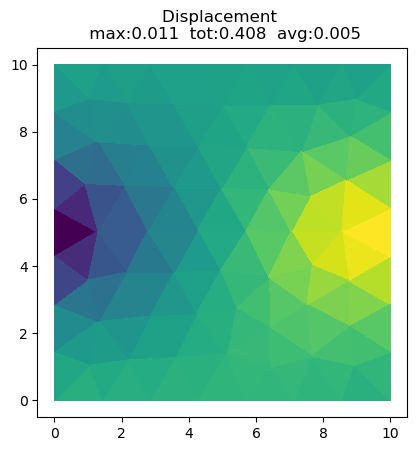

In [20]:
# ATTEMPT 2 - Trying filling in empty triangle voids

def fill_holes(meshpath, infill_vec, infill_connect, infill_coords, verbosity=1, run_GUI=False):
    size = 10  # physical dimension of the side
    P = 1      # number of perimeters
    ex = 0.5   # extrusion width (one perimeter width)
    width, height = size, size       # setting up the square
    num_el_x, num_el_y = 2 * size, 2 * size  # adjust the num of elements
    num_el_x_inf, num_el_y_inf = 7, 7  # adjust num of elems for infill
    dx, dy = width / num_el_x, height / num_el_y

    # initialize Gmsh
    if not gmsh.is_initialized():
        gmsh.initialize()
        gmsh.option.setNumber('General.Verbosity', verbosity)

    print('inf_vec', infill_vec)
    print('inf_con', infill_connect)
    print('inf_coords', infill_coords)

    gmsh.model.add(meshpath.stem)  # "smallSquare8-vecEl-substractive"

    # preparing parameters
    lc = 3 * ex     # mesh size

    # defining a namespace
    gmo = gmsh.model.occ  # gmo ~ gmsh.model.opencascade
    gmg = gmsh.model.geo  # gmg ~ gmsh.model.geo

    # defining the points
    gmo.addPoint(0, 0, 0, lc, 1)
    gmo.addPoint(0, size, 0, lc, 2)
    gmo.addPoint(size, size, 0, lc, 3)
    gmo.addPoint(size, 0, 0, lc, 4)

    # adding lines
    gmo.addLine(1, 2, 1)
    gmo.addLine(2, 3, 2)
    gmo.addLine(3, 4, 3)
    gmo.addLine(4, 1, 4)

    # defining a new surface:
    gmo.addCurveLoop([1, 2, 3, 4], 20)
    surf = gmo.addPlaneSurface([20])  # full surface
    gmo.synchronize()

    # meshing the transfinite surface
    gmsh.model.mesh.setTransfiniteCurve(1, num_el_x + 1)
    gmsh.model.mesh.setTransfiniteCurve(2, num_el_x + 1)
    gmsh.model.mesh.setTransfiniteCurve(3, num_el_x + 1)
    gmsh.model.mesh.setTransfiniteCurve(4, num_el_x + 1)
    gmo.synchronize()
    gmsh.model.mesh.setTransfiniteSurface(surf, arrangement="Alternate", cornerTags=[1,2,3,4])


    # subtracting individual infill elements
    infill_points = []   # list of point tags inside the infill
    for x, y in infill_coords:
        infill_points.append(gmo.addPoint(x, y, 0, lc))  # add each point

    infill_lines = []   # list of line tags inside the infill
    infill_curves = []  # list of curve tags inside the infill
    infill_surfs = []   # list of surface tags
    for i, tri in enumerate(infill_connect):   # get each point in each triangle
        if infill_vec[i] == 0:                 # only if is to be deleted (0: not included)
            p1, p2, p3 = tri[0], tri[1], tri[2]
            tp1 = infill_points[p1]  # tag of p1
            tp2 = infill_points[p2]  # tag of p2
            tp3 = infill_points[p3]  # tag of p3
            l1 = gmo.addLine(tp1, tp2)  # tag of line 1
            l2 = gmo.addLine(tp2, tp3)  # tag of line 2
            l3 = gmo.addLine(tp3, tp1)  # tag of line 3
            xp1, yp1 = infill_coords[p1, 0], infill_coords[p1, 1]  # getting coords of p1
            xp2, yp2 = infill_coords[p2, 0], infill_coords[p2, 1]  # getting coords of p2
            xp3, yp3 = infill_coords[p3, 0], infill_coords[p3, 1]  # getting coords of p3
            infill_lines.append(l1)
            infill_lines.append(l2)
            infill_lines.append(l3)
            c1 = gmo.addCurveLoop([l1, l2, l3])
            s1 = gmo.addPlaneSurface([c1])  # create the surface
            infill_curves.append(c1)
            infill_surfs.append(s1)
    gmo.synchronize()

    surfs_to_cut = [(2, tag) for tag in infill_surfs]  # list of all surfs
    if len(surfs_to_cut) > 0:
        # substract all in one
        outlab = gmo.cut([(2, surf)], surfs_to_cut, removeObject=True, removeTool=True)
        surf = outlab[0][0][1]
        gmo.synchronize()

    # extract the curve boundary
    Boundary = [tg for tp, tg in gmsh.model.getBoundary([(2, surf)])]
    AbsBoundary = [abs(tg) for tp, tg in gmsh.model.getBoundary([(2, surf)])]
    print('Boundary', Boundary)###

    # Select the points and lines withing a bounding box (geometrical search):

    eps = 1
    Xs = np.linspace(0, size, 9)
    Ys = np.linspace(0, size, 9)
    for X1 in Xs:
        for Y1 in Ys:
            X1, Y1 = 1, 1
            X2, Y2 = X1 + 1, Y1 + 1
            ls = gmsh.model.getEntitiesInBoundingBox(X1 - eps, Y1 - eps, 0 - eps,
                                                     X2 + eps, Y2 + eps, 0 + eps, 1)
            ls_tgs = [tg for tp, tg in ls]
            tri = []
            for ls in ls_tgs:
                if ls in AbsBoundary:
                    ind = AbsBoundary.index(ls)
                    tri.append(Boundary[ind])
            if len(tri) == 3:
                print('We have triangle!', tri)

                # trying to first duplicate the lines
                p1 = gmsh.model.getAdjacencies(1, abs(tri[0]))[1][0]
                p2 = gmsh.model.getAdjacencies(1, abs(tri[0]))[1][1]
                p3 = gmsh.model.getAdjacencies(1, abs(tri[1]))[1][0]
                p4 = gmsh.model.getAdjacencies(1, abs(tri[1]))[1][1]
                p5 = gmsh.model.getAdjacencies(1, abs(tri[2]))[1][0]
                p6 = gmsh.model.getAdjacencies(1, abs(tri[2]))[1][1]
                ps = list(set([p1, p2, p3, p4, p5, p6]))


                print('adj ps', p1, p2, p3, p4, p5, p6)###
                print('set adj', set([p1, p2, p3, p4, p5, p6]))

                x1, y1, z = gmsh.model.getValue(0, ps[0], [])  # get coordinates of the point 0
                x2, y2, z = gmsh.model.getValue(0, ps[1], [])  # get coordinates of the point 1
                x3, y3, z = gmsh.model.getValue(0, ps[2], [])  # get coordinates of the point 2

                epsilon = 0.0  # value of outline shift
                # get outlined coordinates
                mx, Mx = min([x1, x2, x3]), max([x1, x2, x3])
                my, My = min([y1, y2, y3]), max([y1, y2, y3])
                if x1 == mx:
                    x1 -= 2*epsilon
                elif x1 == Mx:
                    x1 += epsilon
                if x2 == mx:
                    x2 -= 2*epsilon
                elif x2 == Mx:
                    x2 += epsilon
                if x3 == mx:
                    x3 -= 2*epsilon
                elif x3 == Mx:
                    x3 += epsilon

                if y1 == my:
                    y1 -= 2 * epsilon
                elif y1 == My:
                    y1 += epsilon
                if y2 == my:
                    y2 -= 2 * epsilon
                elif y2 == My:
                    y2 += epsilon
                if y3 == my:
                    y3 -= 2 * epsilon
                elif y3 == My:
                    y3 += epsilon

                # x1, x2, x3 = round( 2 * x1,0)/2, round(2*x2,0)/2, round(2*x3,0)/2
                # y1, y2, y3 = round(2 * y1,0)/2, round(2*y2,0)/2, round(2*y3,0)/2
                gmo.synchronize()
                # extract the coordinates of points

                pp1 = gmo.addPoint(x2, y2, 0, lc)
                pp2 = gmo.addPoint(x1, y1, 0, lc)
                pp3 = gmo.addPoint(x3, y3, 0, lc)

                print(x1, y1)
                print(x2, y2)
                print(x3, y3)
                # pp1 = gmo.addPoint(0.5, 2.5, 0, lc)
                # pp2 = gmo.addPoint(2.5, 2.5, 0, lc)
                # pp3 = gmo.addPoint(2.5, 0.5, 0, lc)
                # print('adj ps copies', pp1, pp2, pp3)###

                # create new lines
                t1 = gmo.addLine(pp1, pp2)
                t2 = gmo.addLine(pp2, pp3)
                t3 = gmo.addLine(pp3, pp1)
                print('t1', t1, t2, t3)

                c1 = gmo.addCurveLoop([t1, t2, t3]) # setting up the curve loop
                patch = gmo.addPlaneSurface([c1])   # create the surface
                gmo.synchronize()

                # now we want to fuse hole back
                outlab = gmo.fuse([(2, surf)], [(2, patch)], removeObject=True, removeTool=False)
                gmo.synchronize()
                print('outl',outlab)###
                surf = outlab[0][0][1]

                # extract the new curve boundary
                Boundary = [tg for tp, tg in gmsh.model.getBoundary([(2, surf)])]
                print(Boundary)
                gmo.synchronize()


    # print('inf_vec', infill_vec)
    # print('inf_coord', infill_coords)

    # adding physical groups
    gmsh.model.addPhysicalGroup(1, Boundary, name="SurfaceLoop") # curves physical group
    gmsh.model.addPhysicalGroup(2, [surf], name="PerimeterSurface")   # surfaces physical group
    gmo.synchronize()


    # global meshing options
    gmsh.option.setNumber("Mesh.Algorithm", 6)  # Frontal-Delaunay for 2D meshes


    # generate the mesh
    gmo.synchronize()
    gmsh.model.mesh.generate(2)

    # saving the mesh
    gmsh.write(str(meshpath))

    # Launch the GUI
    if run_GUI:
        gmo.synchronize()
        gmsh.fltk.run()

    # finish the GMSH session
    gmsh.finalize()

import meshio
import gmsh
from ufl import nabla_div

cwd = Path.cwd()
mesh_dir = cwd.joinpath("MOEA_meshes", "smallSquare7x7test")  # adjust the dir here
inf_file = str(mesh_dir.stem) + '-infill.msh'
mesh_inp = mesh_dir / inf_file

# Extracting geometry from the infill mesh
conn, coords, num_el = extract_mesh_data(mesh_inp)

# Create the mesh infill based on the infill vector
vec = [1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]
meshfile = mesh_dir / 'infill_gen.msh'
fill_holes(meshfile, vec, conn, coords, run_GUI=1)

# Loading the created infill mesh to FEniCS
mesh, _, _, _ = extract_mesh_data_fenics(meshfile)

# perform FEA and obtain displacements and von mises stress
d_max, d_tot, d_avg, max_vm = square_FEA(mesh, verbose=True, plotting=True)

print(d_max)
print(max_vm)

In [1]:
# gmsh fusion testing - this works...

# initialize Gmsh
if not gmsh.is_initialized():
    gmsh.initialize()


gmsh.model.add('testmesh')  # "smallSquare8-vecEl-substractive"

# preparing parameters
lc = 1     # mesh size

# defining a namespace
gmo = gmsh.model.occ  # gmo ~ gmsh.model.opencascade
gmg = gmsh.model.geo  # gmg ~ gmsh.model.geo

# defining the points
gmo.addPoint(0, 0, 0, lc, 1)
gmo.addPoint(0, 10, 0, lc, 2)
gmo.addPoint(10, 10, 0, lc, 3)
gmo.addPoint(10, 0, 0, lc, 4)

# adding lines
gmo.addLine(1, 2, 1)
gmo.addLine(2, 3, 2)
gmo.addLine(3, 4, 3)
gmo.addLine(4, 1, 4)

# hole
gmo.addPoint(1, 1, 0, lc, 5)
gmo.addPoint(1, 2, 0, lc, 6)
gmo.addPoint(2, 1, 0, lc, 7)
gmo.addLine(5, 6, 5)
gmo.addLine(6, 7, 6)
gmo.addLine(7, 5, 7)


# add surfaces
gmo.addCurveLoop([1, 2, 3, 4], 20)
gmo.addCurveLoop([5, 6, 7], 21)
surf = gmo.addPlaneSurface([20, 21])  # full surface

# now we want to fuse hole back
patch = gmo.addPlaneSurface([21])
outlab = gmo.fuse([(2, surf)], [(2, patch)], removeObject=True, removeTool=False)
gmo.synchronize()
print('outl',outlab)###
surf = outlab[0][0][1]

# generate the boundary
Boundary = [tg for tp, tg in gmsh.model.getBoundary([(2, surf)])]
print(Boundary)
gmo.synchronize()

# adding physical groups
gmsh.model.addPhysicalGroup(1, Boundary, name="SurfaceLoop") # curves physical group
gmsh.model.addPhysicalGroup(2, [surf], name="PerimeterSurface")   # surfaces physical group
gmo.synchronize()

# generate the mesh
gmo.synchronize()
gmsh.model.mesh.generate(2)

# saving the mesh
gmsh.write('testingFusion.msh')

# Launch the GUI
if True:
    gmo.synchronize()
    gmsh.fltk.run()

# finish the GMSH session
gmsh.finalize()




NameError: name 'gmsh' is not defined

In [ ]:
arr_img = plt.imread(Path.home() / 'Desktop' / 'test1.png')
plt.imshow(arr_img)

In [ ]:
x = X[0]
p1 = Path.home() / 'Desktop'
ifile = p1 / "test1.png"
generate_img_file(ifile, x, conn, coords)


In [ ]:
# Step 1: SQUARE-OUTLINE + SQUARE-INFILL mesh setup which will work with FEniCS/Dolphin
import gmsh
import pathlib
from pathlib import Path

size = 10  # physical dimension of the side
P = 1      # number of perimeters
ex = 0.5   # extrusion width (one perimeter width)
width, height = size, size       # setting up the square
num_el_x, num_el_y = 2 * size, 2 * size  # adjust the num of elements
num_el_x_inf, num_el_y_inf = 7, 7  # adjust num of elems for infill
dx, dy = width / num_el_x, height / num_el_y


# --- Create the Outline Mesh --------------------------------

# filepath management
path = Path.cwd()
parent_dir = path.joinpath("MOEA_meshes")
parent_dir.mkdir(exist_ok=True)          # create parent dir if it does not exist
meshname = "smallSquare7x7-"              # gmsh model name
mesh_dir = parent_dir.joinpath(meshname) # setting up dir for meshes
mesh_dir.mkdir(exist_ok=True)            # create mesh dir if it does not exist



# initialize Gmsh
if not gmsh.is_initialized():
    gmsh.initialize()

gmsh.model.add(meshname)

# preparing parameters
lc = 1.5 * ex    # mesh size

# defining a namespace
gmg = gmsh.model.geo  # gmg ~ gmsh.model.geo

# defining the points
gmg.addPoint(0, 0, 0, lc, 1)
gmg.addPoint(0, size, 0, lc, 2)
gmg.addPoint(size, size, 0, lc, 3)
gmg.addPoint(size, 0, 0, lc, 4)
gmg.addPoint(0 + P * ex, 0 + P * ex, 0, lc, 5)
gmg.addPoint(0 + P * ex, size - P * ex, 0, lc, 6)
gmg.addPoint(size - P * ex, size - P * ex, 0, lc, 7)
gmg.addPoint(size - P * ex, 0 + P * ex, 0, lc, 8)



# adding lines
gmg.addLine(1, 2, 1)
gmg.addLine(2, 3, 2)
gmg.addLine(3, 4, 3)
gmg.addLine(4, 1, 4)

gmg.addLine(5, 6, 5)
gmg.addLine(6, 7, 6)
gmg.addLine(7, 8, 7)
gmg.addLine(8, 5, 8)

# defining a new surface:
gmg.addCurveLoop([1, 2, 3, 4], 20)
gmg.addCurveLoop([5, 6, 7, 8], 21)


gmg.addPlaneSurface([20, 21], 1)  # perimeter surface
#gmg.addPlaneSurface([24], 5)  # inner/infill surface   ### INFILL

# synchronize the model
gmg.synchronize()

# adding physical groups
# gmsh.model.addPhysicalGroup(1, [1, 2, 3, 4, 5, 6, 7, 8], name="outerLoop") # curves physical group
# gmsh.model.addPhysicalGroup(1, [9, 10, 11, 12], name="innerLoop") # curves physical group
# gmsh.model.addPhysicalGroup(2, [1, 2, 3, 4], name="PerimeterSurface")   # surfaces physical group
gmg.synchronize()

# global meshing options
gmsh.option.setNumber("Mesh.Algorithm", 6)  # Frontal-Delaunay for 2D meshes

# generate the mesh
gmg.synchronize()
gmsh.model.mesh.generate(2)

# saving the mesh
gmsh.write(str(mesh_dir.joinpath(meshname + '.msh')))

# Launch the GUI
gmg.synchronize()
gmsh.fltk.run()

# finish the session
gmsh.finalize()


# --- Create the Infill Mesh ----------------------------------------

# initialize Gmsh
if not gmsh.is_initialized():
    gmsh.initialize()

meshname = meshname + "-infill"
gmsh.model.add(meshname)

# preparing parameters
Fn = 1       # finest of the mesh
lc = 2 * ex  # mesh size

# defining a namespace
gmg = gmsh.model.geo  # gmg ~ gmsh.model.geo

# defining the points
# gmg.addPoint(0, 0, 0, lc, 1)
# gmg.addPoint(0, size, 0, lc, 2)
# gmg.addPoint(size, size, 0, lc, 3)
# gmg.addPoint(size, 0, 0, lc, 4)
gmg.addPoint(0 + P * ex, 0 + P * ex, 0, lc, 5)
gmg.addPoint(0 + P * ex, size - P * ex, 0, lc, 6)
gmg.addPoint(size - P * ex, size - P * ex, 0, lc, 7)
gmg.addPoint(size - P * ex, 0 + P * ex, 0, lc, 8)



# adding lines
# gmg.addLine(1, 2, 1)
# gmg.addLine(2, 3, 2)
# gmg.addLine(3, 4, 3)
# gmg.addLine(4, 1, 4)

gmg.addLine(5, 6, 5)
gmg.addLine(6, 7, 6)
gmg.addLine(7, 8, 7)
gmg.addLine(8, 5, 8)

# defining a new surface:
gmg.addCurveLoop([5, 6, 7, 8], 22)
gmg.addPlaneSurface([22], 1)  # infill surface

# synchronize the model
gmg.synchronize()

gmg.mesh.setTransfiniteCurve(5, Fn * (num_el_y_inf + 1))
gmg.mesh.setTransfiniteCurve(6, Fn * (num_el_x_inf + 1))
gmg.mesh.setTransfiniteCurve(7, Fn * (num_el_y_inf + 1))
gmg.mesh.setTransfiniteCurve(8, Fn * (num_el_x_inf + 1))
gmg.synchronize()

# meshing the transfinite surface
gmg.mesh.setTransfiniteSurface(1, "Alternate", [5, 6, 7, 8])  # set up the corners of interpolation   ### INFILL

# synchronize the model
gmg.synchronize()


# adding physical groups
# gmsh.model.addPhysicalGroup(2, [1], name="InfillSurface")   # surfaces physical group
gmg.synchronize()

# global meshing options
gmsh.option.setNumber("Mesh.Algorithm", 6)  # Frontal-Delaunay for 2D meshes

# generate the mesh
gmg.synchronize()
gmsh.model.mesh.generate(2)

# saving the mesh
gmsh.write(str(mesh_dir.joinpath(meshname + '.msh')))

# Launch the GUI
gmg.synchronize()
gmsh.fltk.run()

# finish the session
gmsh.finalize()


In [4]:
###
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.offsetbox import TextArea, DrawingArea, OffsetImage, AnnotationBbox
import pathlib
from pathlib import Path

cwd = Path.cwd()
mesh_dir = cwd.joinpath("MOEA_meshes", "smallSquare7x7")  # adjust the dir here
out_dir = mesh_dir / "infill_gen-ASF-2000g"
img_dir = out_dir / "png"

# load solutions from the txt file
with open(out_dir / "sq_solutions.txt", "r") as f:
    lines = f.readlines()
    header = lines[0]
    text = lines[1:]

    X = []
    F1, F2 = [], [], []
    for i, line in enumerate(text):


'''

# save solutions
# out_dir = mesh_dir / "infill_gen"
# img_dir = out_dir / "png"
# out_dir.mkdir(exist_ok=True)
# img_dir.mkdir(exist_ok=True)
# for i, x in enumerate(X):
#     ifile = out_dir / f"sol{i:02d}.msh"  # generate mesh
#     generate_infill_file(ifile, x, conn, coords)
#     imfile = img_dir / f"sol_{i}.png"    # generate png
#     generate_img_file(imfile, x, conn, coords)
#     print(f"File {ifile.name} saved.")###

# writing to a file
# with open(out_dir / "sq_solutions.txt", "w+") as file:
#     alg = str(type(algorithm))[8:-2]
#     header = f"Algorithm:{alg}, pop_size: {algorithm.pop_size},\
#      n_offsp: {algorithm.n_offsprings}, n_gen: {termination.n_max_gen},\
#      t_tot: {res.exec_time:10.1f}, t_gen: {res.exec_time/termination.n_max_gen:10.2f}\n"
#     file.writelines(header)
#     file.writelines(f"{str(list(sol))} \t w: {F[i][0]:10.1f} \t vm: {F[i][1]:10.06f} \n" for i, sol in enumerate(1*X))

# plotting the decision space
xl, xu = problem.bounds()
plt.figure(figsize=(7, 5))
plt.imshow(X)
plt.title("Design Space")
plt.show()


# plotting the objective space
plt.figure(figsize=(5, 3))
plt.scatter(F[:, 0], F[:, 1], s=20, facecolors='black', edgecolors='black')
plt.title("Objective Space")
plt.savefig(out_dir / 'ObjectiveSpace.png')
plt.show()


# Multi-Criteria Decision Making: subset selection
n_keep = 9  # how many solutions should we keep
if len(X) > n_keep:
    approx_ideal = F.min(axis=0)  # ideal point
    approx_nadir = F.max(axis=0)  # nadir point

    # normalizing with respect to both objectives
    nF = (F - approx_ideal) / (approx_nadir - approx_ideal)  # normalized objectives

    # Decision making: Using Augmented Scalarization Function (ASF)
    decomp = ASF()                  # init the ASF metric to be minimized
    weights = [np.array([(k + 1)/(n_keep+1), (n_keep - k)/(n_keep+1)]) for k in range(n_keep)]
    best_ASF = []  # indexes of chosen solutions
    for weight in weights:
        best_ASF.append(decomp.do(nF, 1/weight).argmin())  # index of the best solution regarding ASF
    best_ASF = list(set(best_ASF))  # remove duplicates
    F_ASF = F[best_ASF, :]          # objectives
    X_ASF = X[best_ASF, :]          # solutions
    n_kept = len(best_ASF)          # number of kept solutions


    # plotting the objective space with mesh png annotations
    fig, ax = plt.subplots(figsize=(13, 8))
    plt.scatter(F_ASF[:, 0], F_ASF[:, 1], s=20, facecolors='black', edgecolors='black')

    for i, (x, y) in enumerate(F_ASF):
        ind = best_ASF[i]
        img_lab = plt.imread(img_dir / f"sol_{ind}.png")
        imagebox = OffsetImage(img_lab, zoom=0.045)
        imagebox.image.axes = ax

        fl_offset = (-1)**i * 20  # spreading fluctuating offset
        ab = AnnotationBbox(imagebox, (x, y),
                            xybox=(32 - 0.6 * fl_offset, 38 + fl_offset),
                            xycoords='data',
                            boxcoords=("offset points", "offset points"),
                            pad=-1,
                            arrowprops=dict(
                                arrowstyle="->",
                                connectionstyle="angle,angleA=0,angleB=90,rad=3",
                                linewidth=0.5)
                            )
        ax.add_artist(ab)
        ax.text(x, y, f"  {str(ind)}", va='top', ha='left', zorder=4)

    xrang = np.abs(np.max(F_ASF[:,0]) - np.min(F_ASF[:,0]))
    yrang = np.abs(np.max(F_ASF[:,1]) - np.min(F_ASF[:,1]))
    ax.set_xlim((np.min(F_ASF[:,0]) - 0.05*xrang, np.max(F_ASF[:,0]) + 0.15*xrang ))
    ax.set_ylim((np.min(F_ASF[:,1]) - 0.1*yrang, np.max(F_ASF[:,1]) + 0.25*yrang ))
    plt.title(f"Objective Space of {n_kept} ASF-selected solutions")
    plt.savefig(out_dir / 'ObjectiveSpace-ASF.png')
    plt.show()'''

Algorithm:pymoo.algorithms.moo.nsga2.NSGA2, pop_size: 100,     n_offsp: 40, n_gen: 2000,     t_tot:    14230.8, t_gen:       7.12



'\n\n# save solutions\n# out_dir = mesh_dir / "infill_gen"\n# img_dir = out_dir / "png"\n# out_dir.mkdir(exist_ok=True)\n# img_dir.mkdir(exist_ok=True)\n# for i, x in enumerate(X):\n#     ifile = out_dir / f"sol{i:02d}.msh"  # generate mesh\n#     generate_infill_file(ifile, x, conn, coords)\n#     imfile = img_dir / f"sol_{i}.png"    # generate png\n#     generate_img_file(imfile, x, conn, coords)\n#     print(f"File {ifile.name} saved.")###\n\n# writing to a file\n# with open(out_dir / "sq_solutions.txt", "w+") as file:\n#     alg = str(type(algorithm))[8:-2]\n#     header = f"Algorithm:{alg}, pop_size: {algorithm.pop_size},#      n_offsp: {algorithm.n_offsprings}, n_gen: {termination.n_max_gen},#      t_tot: {res.exec_time:10.1f}, t_gen: {res.exec_time/termination.n_max_gen:10.2f}\n"\n#     file.writelines(header)\n#     file.writelines(f"{str(list(sol))} \t w: {F[i][0]:10.1f} \t vm: {F[i][1]:10.06f} \n" for i, sol in enumerate(1*X))\n\n# plotting the decision space\nxl, xu = proble

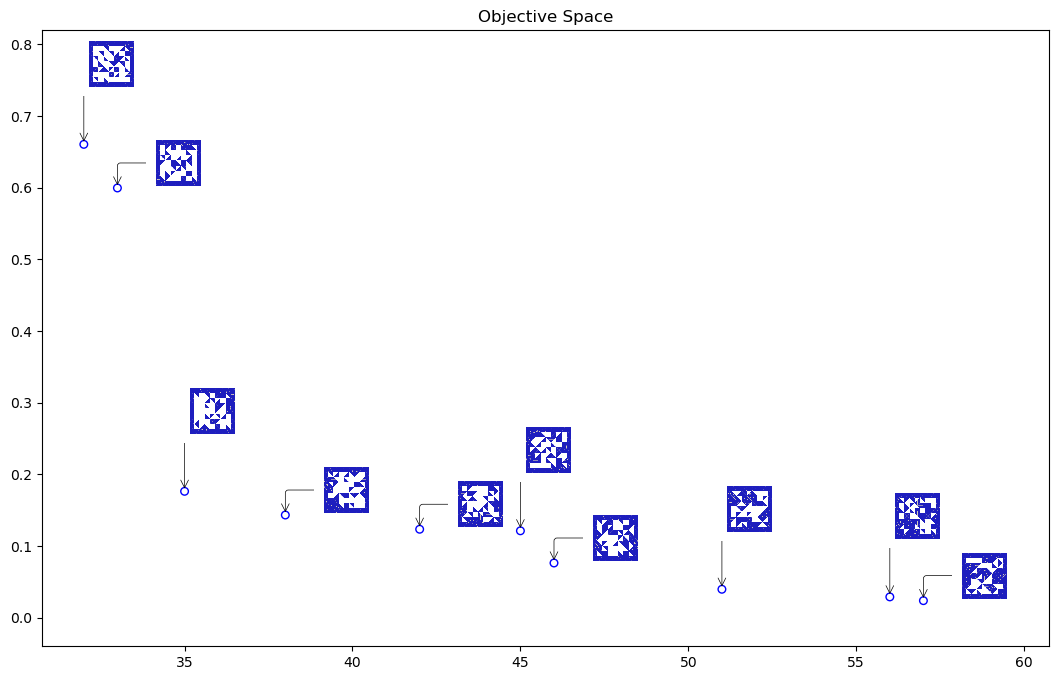

In [454]:
# plotting obj. with infill-visualisation images
from matplotlib.offsetbox import TextArea, DrawingArea, OffsetImage, AnnotationBbox

# plotting the objective space
fig, ax = plt.subplots(figsize=(13, 8))
plt.scatter(F[:, 0], F[:, 1], s=30, facecolors='none', edgecolors='blue')

for i, (x, y) in enumerate(F):
    img_lab = plt.imread(img_dir / f"sol_{i}.png")
    imagebox = OffsetImage(img_lab, zoom=0.035)
    imagebox.image.axes = ax

    fl_offset = (-1)**i * 20

    ab = AnnotationBbox(imagebox, (x, y),
                        xybox=(32 - 0.6 * fl_offset, 38 + fl_offset),
                        xycoords='data',
                        boxcoords=("offset points", "offset points"),
                        pad=-1,
                        arrowprops=dict(
                           arrowstyle="->",
                           connectionstyle="angle,angleA=0,angleB=90,rad=3",
                           linewidth=0.5)
                        )
    ax.add_artist(ab)

xrang = np.abs(np.max(F[:,0]) - np.min(F[:,0]))
yrang = np.abs(np.max(F[:,1]) - np.min(F[:,1]))
ax.set_xlim((np.min(F[:,0]) - 0.05*xrang, np.max(F[:,0]) + 0.15*xrang ))
ax.set_ylim((np.min(F[:,1]) - 0.1*yrang, np.max(F[:,1]) + 0.25*yrang ))
plt.title("Objective Space")
plt.show()

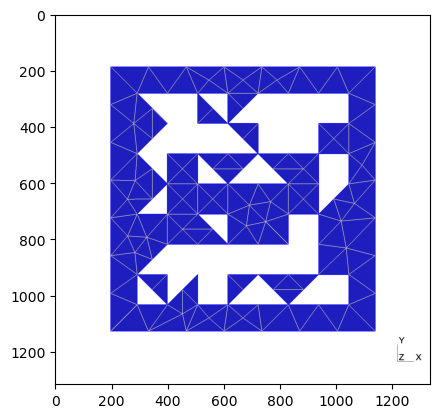

In [355]:
arr_img = plt.imread(Path.home() / 'Desktop' / 'test1.png')
plt.imshow(arr_img)

In [228]:
Path.home() / 'Desktop'

PosixPath('/Users/macbookpro/Desktop')

In [249]:
x = X[0]
p1 = Path.home() / 'Desktop'
ifile = p1 / "test1.png"
generate_img_file(ifile, x, conn, coords)


Error   : Could not set option 'Mesh.Color.SurfaceFaces'


Exception: Could not set option 'Mesh.Color.SurfaceFaces'

In [35]:
# Step 1: SQUARE-OUTLINE + SQUARE-INFILL mesh setup which will work with FEniCS/Dolphin
import gmsh
import pathlib
from pathlib import Path

size = 10  # physical dimension of the side
P = 1      # number of perimeters
ex = 0.5   # extrusion width (one perimeter width)
width, height = size, size       # setting up the square
num_el_x, num_el_y = 2 * size, 2 * size  # adjust the num of elements
num_el_x_inf, num_el_y_inf = 7, 7  # adjust num of elems for infill
dx, dy = width / num_el_x, height / num_el_y


# --- Create the Outline Mesh --------------------------------

# filepath management
path = Path.cwd()
parent_dir = path.joinpath("MOEA_meshes")
parent_dir.mkdir(exist_ok=True)          # create parent dir if it does not exist
meshname = "smallSquare7x7-"              # gmsh model name
mesh_dir = parent_dir.joinpath(meshname) # setting up dir for meshes
mesh_dir.mkdir(exist_ok=True)            # create mesh dir if it does not exist



# initialize Gmsh
if not gmsh.is_initialized():
    gmsh.initialize()

gmsh.model.add(meshname)

# preparing parameters
lc = 1.5 * ex    # mesh size

# defining a namespace
gmg = gmsh.model.geo  # gmg ~ gmsh.model.geo

# defining the points
gmg.addPoint(0, 0, 0, lc, 1)
gmg.addPoint(0, size, 0, lc, 2)
gmg.addPoint(size, size, 0, lc, 3)
gmg.addPoint(size, 0, 0, lc, 4)
gmg.addPoint(0 + P * ex, 0 + P * ex, 0, lc, 5)
gmg.addPoint(0 + P * ex, size - P * ex, 0, lc, 6)
gmg.addPoint(size - P * ex, size - P * ex, 0, lc, 7)
gmg.addPoint(size - P * ex, 0 + P * ex, 0, lc, 8)



# adding lines
gmg.addLine(1, 2, 1)
gmg.addLine(2, 3, 2)
gmg.addLine(3, 4, 3)
gmg.addLine(4, 1, 4)

gmg.addLine(5, 6, 5)
gmg.addLine(6, 7, 6)
gmg.addLine(7, 8, 7)
gmg.addLine(8, 5, 8)

# defining a new surface:
gmg.addCurveLoop([1, 2, 3, 4], 20)
gmg.addCurveLoop([5, 6, 7, 8], 21)


gmg.addPlaneSurface([20, 21], 1)  # perimeter surface
#gmg.addPlaneSurface([24], 5)  # inner/infill surface   ### INFILL

# synchronize the model
gmg.synchronize()

# adding physical groups
# gmsh.model.addPhysicalGroup(1, [1, 2, 3, 4, 5, 6, 7, 8], name="outerLoop") # curves physical group
# gmsh.model.addPhysicalGroup(1, [9, 10, 11, 12], name="innerLoop") # curves physical group
# gmsh.model.addPhysicalGroup(2, [1, 2, 3, 4], name="PerimeterSurface")   # surfaces physical group
gmg.synchronize()

# global meshing options
gmsh.option.setNumber("Mesh.Algorithm", 6)  # Frontal-Delaunay for 2D meshes

# generate the mesh
gmg.synchronize()
gmsh.model.mesh.generate(2)

# saving the mesh
gmsh.write(str(mesh_dir.joinpath(meshname + '.msh')))

# Launch the GUI
gmg.synchronize()
gmsh.fltk.run()

# finish the session
gmsh.finalize()


# --- Create the Infill Mesh ----------------------------------------

# initialize Gmsh
if not gmsh.is_initialized():
    gmsh.initialize()

meshname = meshname + "-infill"
gmsh.model.add(meshname)

# preparing parameters
Fn = 1       # finest of the mesh
lc = 2 * ex  # mesh size

# defining a namespace
gmg = gmsh.model.geo  # gmg ~ gmsh.model.geo

# defining the points
# gmg.addPoint(0, 0, 0, lc, 1)
# gmg.addPoint(0, size, 0, lc, 2)
# gmg.addPoint(size, size, 0, lc, 3)
# gmg.addPoint(size, 0, 0, lc, 4)
gmg.addPoint(0 + P * ex, 0 + P * ex, 0, lc, 5)
gmg.addPoint(0 + P * ex, size - P * ex, 0, lc, 6)
gmg.addPoint(size - P * ex, size - P * ex, 0, lc, 7)
gmg.addPoint(size - P * ex, 0 + P * ex, 0, lc, 8)



# adding lines
# gmg.addLine(1, 2, 1)
# gmg.addLine(2, 3, 2)
# gmg.addLine(3, 4, 3)
# gmg.addLine(4, 1, 4)

gmg.addLine(5, 6, 5)
gmg.addLine(6, 7, 6)
gmg.addLine(7, 8, 7)
gmg.addLine(8, 5, 8)

# defining a new surface:
gmg.addCurveLoop([5, 6, 7, 8], 22)
gmg.addPlaneSurface([22], 1)  # infill surface

# synchronize the model
gmg.synchronize()

gmg.mesh.setTransfiniteCurve(5, Fn * (num_el_y_inf + 1))
gmg.mesh.setTransfiniteCurve(6, Fn * (num_el_x_inf + 1))
gmg.mesh.setTransfiniteCurve(7, Fn * (num_el_y_inf + 1))
gmg.mesh.setTransfiniteCurve(8, Fn * (num_el_x_inf + 1))
gmg.synchronize()

# meshing the transfinite surface
gmg.mesh.setTransfiniteSurface(1, "Alternate", [5, 6, 7, 8])  # set up the corners of interpolation   ### INFILL

# synchronize the model
gmg.synchronize()


# adding physical groups
# gmsh.model.addPhysicalGroup(2, [1], name="InfillSurface")   # surfaces physical group
gmg.synchronize()

# global meshing options
gmsh.option.setNumber("Mesh.Algorithm", 6)  # Frontal-Delaunay for 2D meshes

# generate the mesh
gmg.synchronize()
gmsh.model.mesh.generate(2)

# saving the mesh
gmsh.write(str(mesh_dir.joinpath(meshname + '.msh')))

# Launch the GUI
gmg.synchronize()
gmsh.fltk.run()

# finish the session
gmsh.finalize()


Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 20%] Meshing curve 2 (Line)
Info    : [ 30%] Meshing curve 3 (Line)
Info    : [ 40%] Meshing curve 4 (Line)
Info    : [ 50%] Meshing curve 5 (Line)
Info    : [ 70%] Meshing curve 6 (Line)
Info    : [ 80%] Meshing curve 7 (Line)
Info    : [ 90%] Meshing curve 8 (Line)
Info    : Done meshing 1D (Wall 0.000615728s, CPU 0.001023s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.00329993s, CPU 0.003274s)
Info    : 128 nodes 264 elements
Info    : Writing '/Users/macbookpro/Desktop/Project2023/MOEA_meshes/smallSquare7x7-/smallSquare7x7-.msh'...
Info    : Done writing '/Users/macbookpro/Desktop/Project2023/MOEA_meshes/smallSquare7x7-/smallSquare7x7-.msh'
-------------------------------------------------------
Version       : 4.11.1
License       : GNU General Public License
Build OS      : MacOSX-sdk
Build date    : 20230510
Build host    : Mac-1683750338